# ATSC-411 - SYNOPTIC METEOROLOGY | LAB 1 

### Pressure Gradient Force, Pressure Gradient, & Geopotential Height
##### Welcome! 

... add instructions 

----- 

<br>

## IMPORT PACKAGES 
Run this cell to import Python code packages that will help us get the data, process the data, conduct math operations, and build some maps.

In [3]:
# import packages 
from siphon.catalog import TDSCatalog            # siphon TDSCatalog to access the THREDDS TDS server 
from datetime import datetime                    # datetime for simple date/time objects operations 
import numpy as np                               # numpy for math & number operations
from xarray.backends import NetCDF4DataStore     # xarray NetCDF4DataStore for loading data
import xarray as xr                              # xarray for storing data after download
import scipy.ndimage as ndimage                  # scipy ndimage data filtering/smoothing -- make the data 'prettier'
import cartopy.crs as ccrs                       # cartopy coordinate refrence system for mapping -- to turn a matplotlib axis into a geoaxis (map)
import cartopy.feature as cfeature               # cartopy features (borders, states, oceans, rivers, etc) for mapping -- add map components to a map
import matplotlib.pyplot as plt                  # matplotlib for plotting figures, axes, graphs, etc
import metpy.calc as mpcalc                      # metpy functions for meteorological calculations
from matplotlib.colors import LogNorm            # 
import matplotlib.ticker as ticker               #

import helper_functions as helper                # helper_functions.py; a file of python functions to help load and manipulate data

print("[+] packages imported...")

[+] packages imported...


-----

<br>

## SET UP DATA CONNECTION
Run this cell to load a dataset of RAP model reanalysis data. The function `helper.give_me_rap_data()` returns an `xarray.DataSet()` of RAP data

- Note thats the date variables below must be of type `str`. 
- `bounds` is a list of lat/lon bounds in order of [min_lon, max_lon, min_lat, max_lat]


In [4]:
# date/time components
year  = "2024"
month = "08"
day   = "29"
hour  = "00"

# lat/lon bounds
bounds = [-125, -80, 28, 60]

# load an `xarray` dataset of RAP reanalysis data
# this will take a few seconds to load
rap_data = helper.give_me_rap_data(year, month, day, hour, bounds)

> RAP REANALYSIS DATA ACCESS FUNCTION --
-----------------------------------------
> DATASET USED: RAP_13km
> COMPLETE --------
> RUNTIME: 00:00:14


------

<br>

## CHECKOUT THE DATA
Run the next couple cells to explore the dataset you just downloaded. 

The first cell displays the entire `xarray.DataSet()`

The next cell displays the variables we downloaded.

In [5]:
# display the dataset
rap_data

<xarray.Dataset>
Dimensions:                       (time: 1, y: 253, x: 326, isobaric: 37)
Coordinates:
  * time                          (time) datetime64[ns] 2024-08-29
  * y                             (y) float32 413.4 427.0 ... 3.827e+03
  * x                             (x) float32 -2.926e+03 ... 1.476e+03
  * isobaric                      (isobaric) float32 1e+04 1.25e+04 ... 1e+05
Data variables:
    Pressure_surface              (time, y, x) float32 ...
    LambertConformal_Projection   int32 ...
    lat                           (y, x) float64 ...
    lon                           (y, x) float64 ...
    Geopotential_height_isobaric  (time, isobaric, y, x) float32 ...
    Temperature_isobaric          (time, isobaric, y, x) float32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

-----

<br>

## CREATE DATA VARIABLES
Run this cell to prepare the data for plotting. First we pull out the isobaric levels, latitude and longitude. Next, we pull out the geopotential height data and temperature data. `ndimage.gaussian_filter()` is a smoothing technique that makes the data a little 'prettier' for plotting. Finally, we can 'slice' the data for just the 500hPa level. Note that the data we downloaded is 3D; meaning the data exists along the Y-direction & X-direction (lat/lon) and the vertical direction (isobaric). We will "slice through the data" to pull out data at the 500hPa isobaric level. `np.where(pres_levs == 500)[0][0]` finds 'where' the 500hPa level is within the `pres_levs` array (pressure levels). The 'where' index value is saved as `plev500` (pressure level 500hPa). Then we can index the `ghgt` and `temp` variables at `plev500` to pull out those 500hPa values.

In [6]:
#--------------------------------------------------------------------------------------
# EXTRACT ISOBARIC (PRESSURE) LEVELS, LAT-LON -----------------------------------------
#--------------------------------------------------------------------------------------
pres_levs = rap_data.variables['isobaric'][:]/100 # *note /100 converts Pa to hPa
lat = rap_data.variables['lat'][:]#[:,0]
lon = rap_data.variables['lon'][:]#[0,:]


#--------------------------------------------------------------------------------------
# EXTRACT VARIABLES FROM RAP DATA -----------------------------------------------------
#--------------------------------------------------------------------------------------
ghgt = ndimage.gaussian_filter(rap_data.variables['Geopotential_height_isobaric'][0], sigma=1.0)
temp = ndimage.gaussian_filter(rap_data.variables['Temperature_isobaric'][0], sigma=1.0)


#--------------------------------------------------------------------------------------
# EXTRACT 500hPa LEVEL DATA -----------------------------------------------------------
#--------------------------------------------------------------------------------------
# extract the 500hPa level values from the extracted data variables (above)
# define the "slice" for the 500hPa level
plev500 = np.where(pres_levs == 500)[0][0]
# extract 500hPa heights
ghgt_500 = ghgt[plev500]
temp_500 = temp[plev500]

print("[+] data parsed and ready for use...")

[+] data parsed and ready for use...


-----

<br>


## COMPUTE PRESSURE GRADIENT FORCE & GEOPOTENTIAL HEIGHT GRADIENT


/home/kayla.kenow/und-atsc411-labs/lab_01/helper_functions.py:161: UserWarning: Argument (unnamed) given as xarray Variable...casting to its data. xarray DataArrays are recommended instead.
  pressure_at_height[ilon, ilat] = log_interpolate_1d(target_height,
/home/kayla.kenow/und-atsc411-labs/lab_01/helper_functions.py:195: UserWarning: Argument xp given as xarray Variable...casting to its data. xarray DataArrays are recommended instead.
  temperature_at_height[ilon, ilat] = log_interpolate_1d(pres_aloft[ilon, ilat],


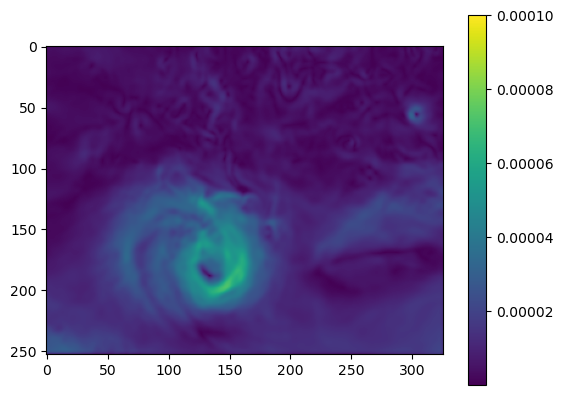

[+] calculations complete...


In [11]:
# -------------------------------------------------------------------------------------
# HORIZONAL PRESSURE GRADIENT FORCE MAGNITUDE -----------------------------------------
#--------------------------------------------------------------------------------------
def pgf_eqn(pressure, rho, lat, lon):
    
    '''
    compute horizonal PGF magnitude on a lat/lon grid 

    where

    pgf = 1/rho * dP/dx
    '''
    #convert latitutde/longitude grid to x/y grid in meters
    projection=ccrs.LambertConformal()
    tmp = projection.transform_points(ccrs.PlateCarree(),lon.values,lat.values)
    x = tmp[:,:,0]
    y = tmp[:,:,1]
    # compute gradients between lat -> lat+1 and lon - > lon+1 of pressure
    # returns two variables, change in pressure with change in latitude, change in pressure with change in longitude
    # dP/dx
    dp_dx, dp_dy = mpcalc.gradient(pressure, coordinates=(y,x))
    #dp_dlon, dp_dlat = np.gradient(pressure, x, y, edge_order=2)

    # compute lat-direction and lon-direction PGF magnitudes (dPdx/rho)
    pgf_x = -dp_dx / rho
    pgf_y = -dp_dy / rho

    # compute overall magnitude of horizontal PGF (magnitude of 2 vectors eqn)
    pgf_magnitude = np.sqrt(pgf_x**2 + pgf_y**2)

    return pgf_magnitude, pgf_x, pgf_y
    




# -------------------------------------------------------------------------------------
# GEOPOTENTIAL HGT GRADIENT -----------------------------------------
#--------------------------------------------------------------------------------------
def grad_calc(geopotential, lat, lon):

    '''
    using numpy's `gradient` function, calculate the gradient 
    of geopotential height
    '''
    #convert latitutde/longitude grid to x/y grid in meters
    projection=ccrs.LambertConformal()
    tmp = projection.transform_points(ccrs.PlateCarree(),lon.values,lat.values)
    x = tmp[:,:,0]
    y = tmp[:,:,1]
    
    # constants
    gravity = 9.80665 # acceleration due to gravity (m/s**2)

    # convert geopotential height to geometeric height
    geometric_height = geopotential / gravity

    # compute gradients between lat -> lat+1 and lon - > lon+1 of geopotential height
    # returns two variables, change in height with change in latitude, change in height with change in longitude
    # dh/dx & dh/dy
    dh_dx, dh_dy = mpcalc.gradient(geometric_height, coordinates=(y,x))

    # compute overall magnitude of the height gradient (magnitude of 2 vectors eqn)
    grad_magnitude = np.sqrt(dh_dx**2 + dh_dy**2)

    return grad_magnitude, dh_dx, dh_dy






# -------------------------------------------------------------------------------------
# COMPUTE VALUES -----------------------------------------
#--------------------------------------------------------------------------------------
# VIA INTERPOLATION, COMPUTE TEMPERATURE & PRESSURE AT A SPECIFIED 'TARGET HEIGHT' (ex: 5000 meters)
# the interpolation will take just a few seconds to run
target_height = 5900 # meters

pres_aloft = helper.pres_at_hgt(ghgt, pres_levs, lat, lon, target_height) # hPa
temp_aloft = helper.temp_at_hgt(temp, pres_levs, lat, lon, pres_aloft) # degC

# COMPUTE AIR DENSITY AT THE SPECIFIED 'TARGET HEIGHT' VIA THE IDEAL GASS LAW
#rho_aloft  = helper.gas_law(pres_aloft, temp_aloft) # kg/m3
rho_aloft = (pres_aloft*100) / (temp_aloft * 287.05)

# COMPUTE PGF AT THE SPECIFIED 'TARGET-HEIGHT'
pgf_aloft, pgf_aloft_x, pgf_aloft_y  = pgf_eqn(pres_aloft, rho_aloft, lat, lon) # Pa/m

plt.imshow(grad_magnitude,vmax=1e-4)
plt.colorbar()
plt.show()

# COMPUTE 500 HPA GEOPOTENIAL HEIGHT GRADIENT
grad_magnitude, dh_dx, dh_dy  = grad_calc(ghgt_500, lat, lon)

print('[+] calculations complete...')

-----

<br>

## PLOT GEOPOTENTIAL HEIGHT, PGF, AND HEIGHT GRADIENT MAPS

Text(0.5, 1.0, '500 hPa Geopotential Height Gradient $\\rm\\bf{(ms^{-2})}$')

/home/kayla.kenow/miniconda3/envs/atsc411/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


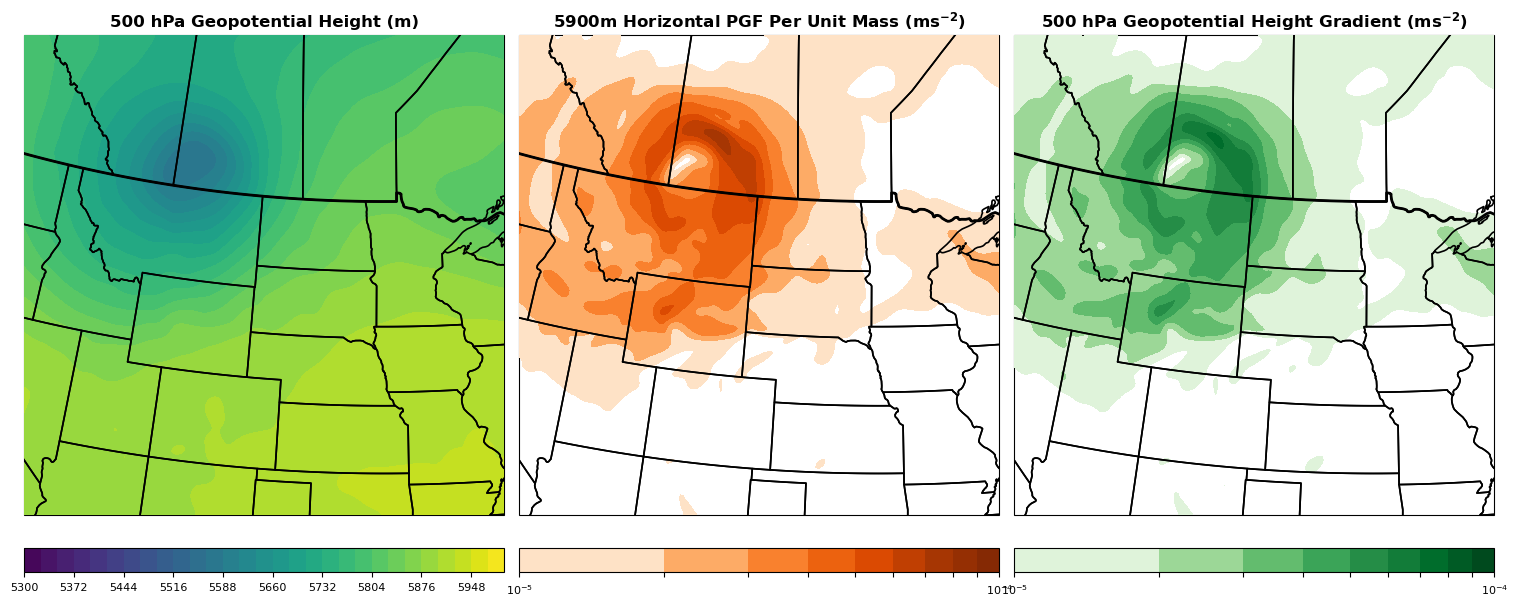

In [14]:
#--------------------------------------------------------------------------------------
# BUILD MAPS FUNCTION -----------------------------------------------------------------
#--------------------------------------------------------------------------------------
# define build maps func
def build_maps(extent=[-115, -90, 35, 55], figsize=(20, 8.5), nrows=2, ncols=1, projection=ccrs.LambertConformal()):

    '''
    build multiple maps function
    '''
    
    # create figure and subplot axes based on user input (args)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                            subplot_kw={'projection': projection}, tight_layout=True)
    
    # flatten array of axes for easy iteration
    axs = axs.flatten()
    
    # for each axis, apply extent, map aspect ratio, states and country borders
    for ax in axs:
        ax.set_extent(extent)
        ax.set_box_aspect(1)
        ax.add_feature(cfeature.STATES, edgecolor='black', alpha=1, linestyle='-', linewidth=1.2, zorder=10)
        ax.add_feature(cfeature.BORDERS, color='black', alpha=1, linestyle='-', linewidth=2, zorder=11)
    
    # apply tight layout to the figure
    plt.tight_layout()

    # return the figure and the *array* of axes
    return fig, axs


# build the figure and axes
fig, axs = build_maps(figsize=(15, 7), nrows=1, ncols=3)



#--------------------------------------------------------------------------------------
# ADD 500HPA GEOPOTENTIAL HEIGHTS FILLED CONTOUR PLOT ---------------------------------
#--------------------------------------------------------------------------------------
# filled contour plot
ghgt_500_contour = axs[0].contourf(lon, lat, ghgt_500, np.arange(5300, 6000, 24), 
                                   cmap='viridis', zorder=6, transform=ccrs.PlateCarree())
# colorbar
cbar0 = plt.colorbar(ghgt_500_contour, fraction=0.04, ax=axs[0], orientation='horizontal', pad=0.05)
cbar0.ax.tick_params(labelsize=8) 
# title
axs[0].set_title('500 hPa Geopotential Height (m)', weight='bold')  


#--------------------------------------------------------------------------------------
# ADD 500HPA PGF MAGNITUDE FILLED CONTOUR PLOT ----------------------------------------
#--------------------------------------------------------------------------------------
levels = np.arange(1,11)*1e-5
# filled contour plot
pgf_aloft_contour  = axs[1].contourf(lon, lat, pgf_aloft, levels,
                                   cmap='Oranges', zorder=6, transform=ccrs.PlateCarree(), norm = LogNorm())
# colorbar
cbar1 = plt.colorbar(pgf_aloft_contour, fraction=0.04, ax=axs[1], orientation='horizontal', pad=0.05)
#cbar1.formatter.set_powerlimits((0, 0))
cbar1.ax.tick_params(labelsize=8) 
# title
axs[1].set_title(f'{target_height}m Horizontal PGF Per Unit Mass '+ r'$\rm\bf{(ms^{-2})}$', weight='bold')  


#--------------------------------------------------------------------------------------
# ADD 500HPA GEOPOTENTIAL GRADIENT ----------------------------------------
#--------------------------------------------------------------------------------------
levels = np.arange(1,11)*1e-5
# filled contour plot
grad_mag_contour  = axs[2].contourf(lon, lat, grad_magnitude, levels,
                                   cmap='Greens', zorder=6, transform=ccrs.PlateCarree(), norm = LogNorm())

# colorbar
cbar2 = plt.colorbar(grad_mag_contour, fraction=0.04, ax=axs[2], orientation='horizontal', pad=0.05)
#cbar2.formatter.set_powerlimits((0, 0))
cbar2.ax.tick_params(labelsize=8) 
# title
axs[2].set_title(r'500 hPa Geopotential Height Gradient $\rm\bf{(ms^{-2})}$', weight='bold')  


-----

<br>

## COMPARING X AND Y COMPONENTS

/home/kayla.kenow/miniconda3/envs/atsc411/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


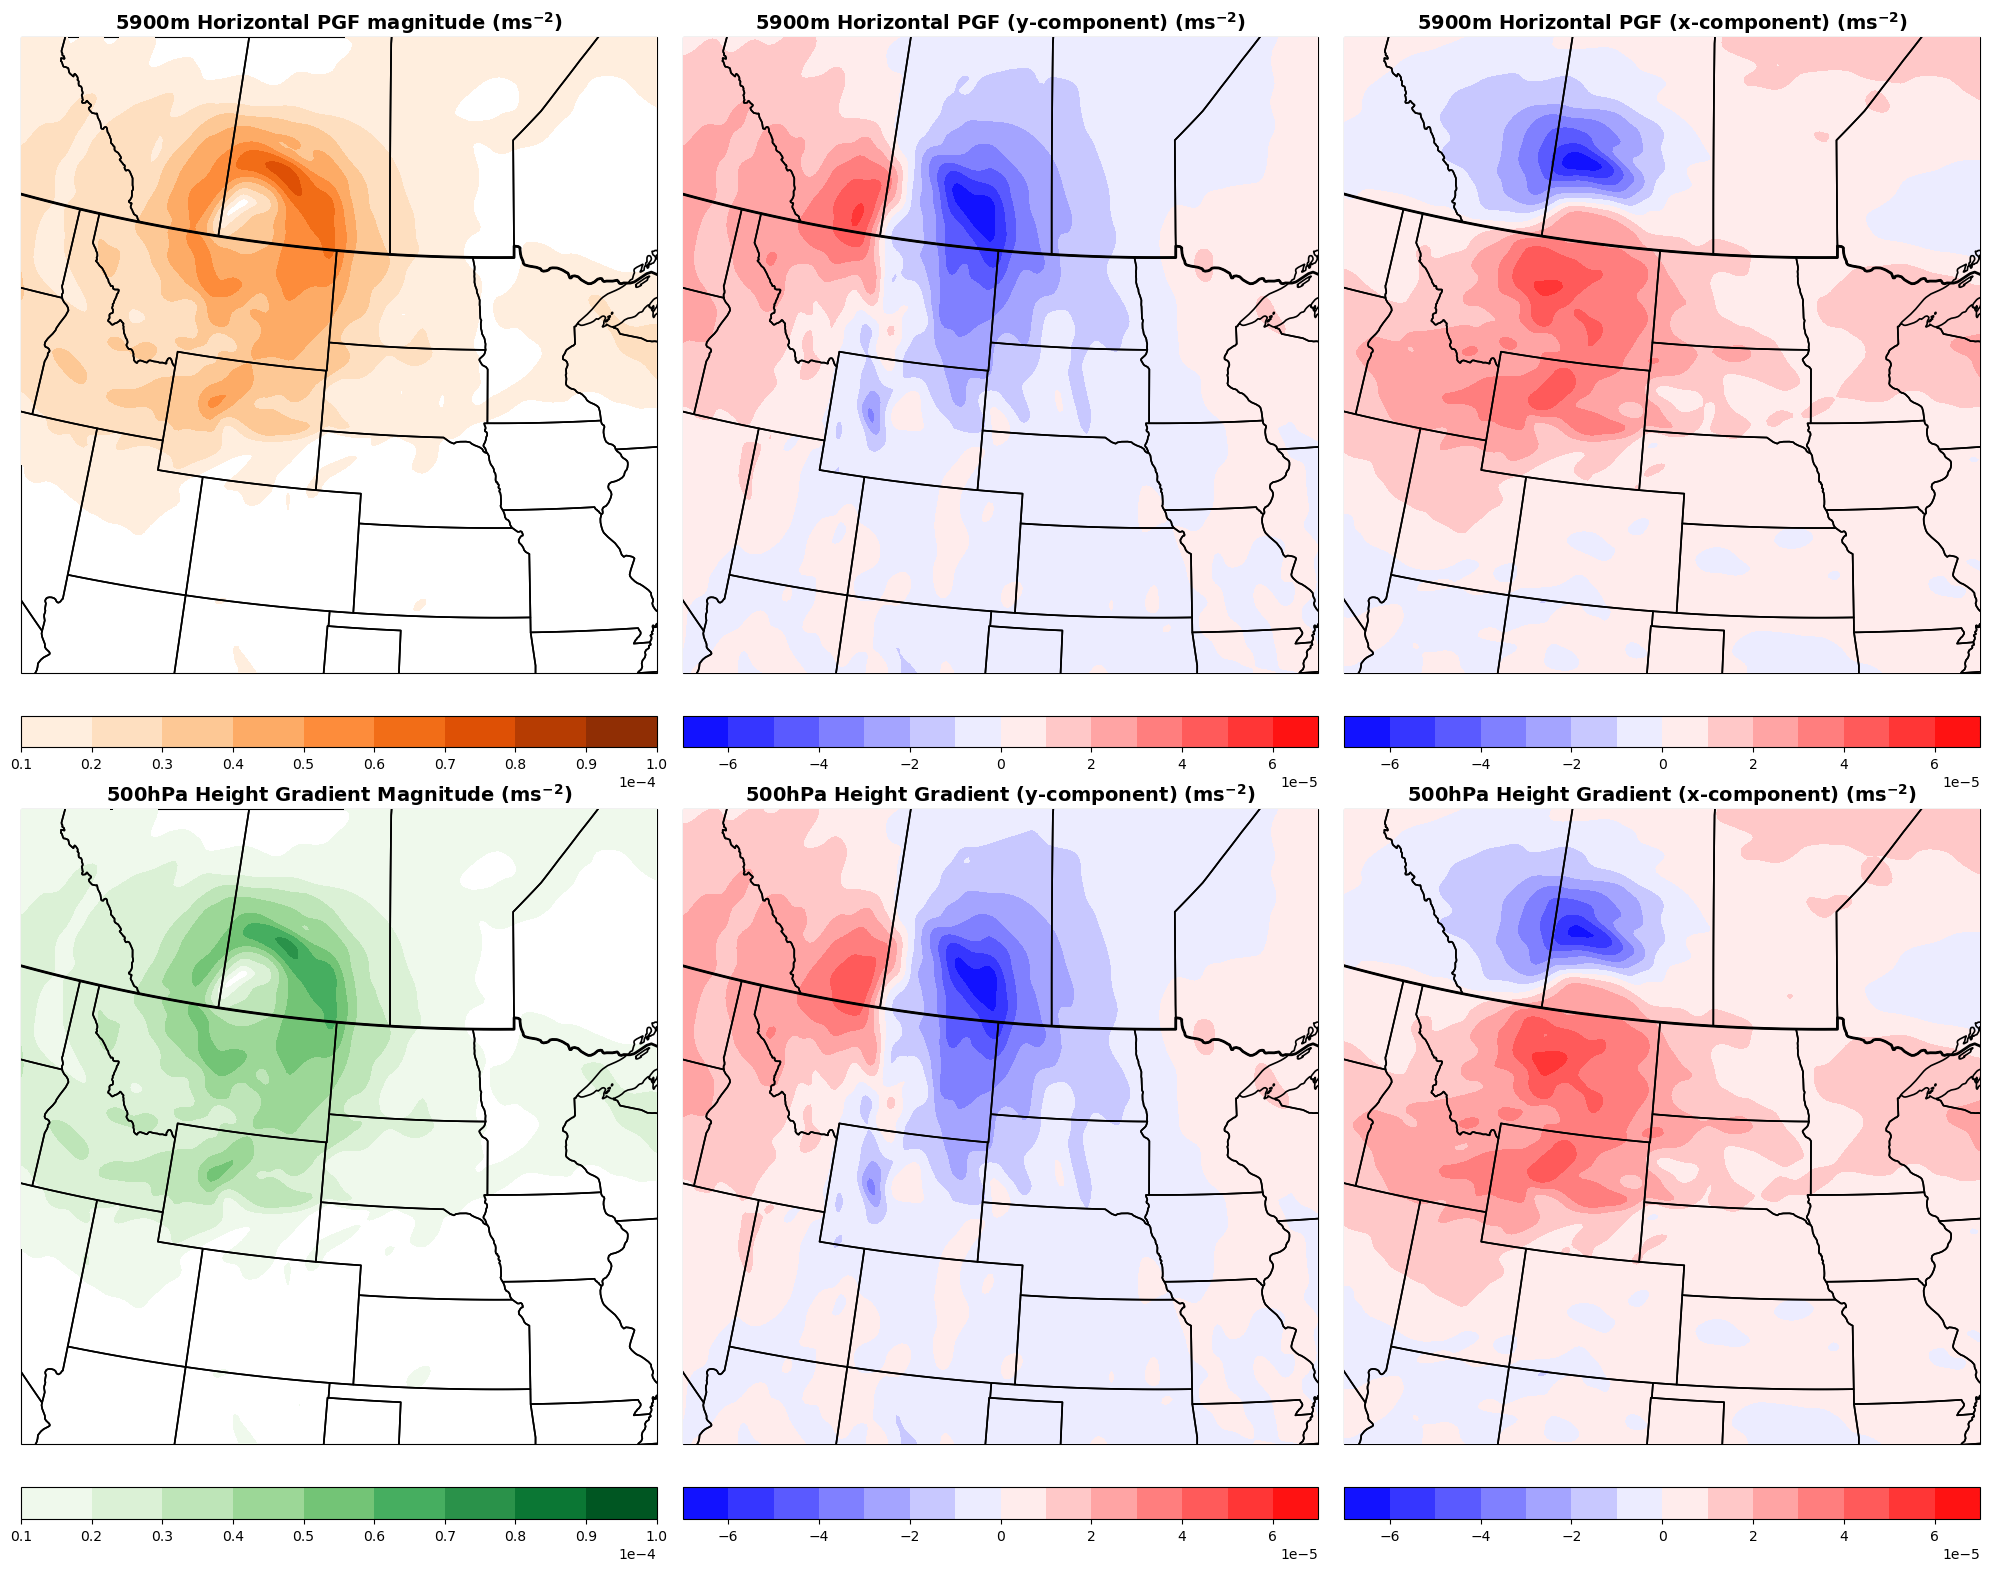

In [20]:
fig, axs = build_maps(figsize=(20, 17), nrows=2, ncols=3)



#--------------------------------------------------------------------------------------
# ADD HORIZONTAL PGF COMPONENTS ----------------------------------------
#--------------------------------------------------------------------------------------
# PGF TOTAL MAGNITUDE ----
levels = np.arange(1,11)*1e-5
pgf_aloft_contour  = axs[0].contourf(lon, lat, pgf_aloft, levels,
                                   cmap='Oranges', zorder=6, transform=ccrs.PlateCarree())
# colorbar
cbar0=plt.colorbar(pgf_aloft_contour, fraction=0.04, ax=axs[0], orientation='horizontal', pad=0.05)
cbar0.formatter.set_powerlimits((0, 0))

# title
axs[0].set_title(f'{target_height}m Horizontal PGF magnitude '+r'$\rm\bf{(ms^{-2})}$', fontsize=14, weight='bold')  



# LATITUDE COMPONENT OF PGF ----
levels = np.linspace(-7e-5,7e-5,15)
pgf_aloft_lat_contour = axs[1].contourf(lon, lat, pgf_aloft_y, levels,
                                   cmap='bwr', zorder=6, transform=ccrs.PlateCarree())
cbar1=plt.colorbar(pgf_aloft_lat_contour, fraction=0.04, ax=axs[1], orientation='horizontal', pad=0.05)
cbar1.formatter.set_powerlimits((0, 0))

axs[1].set_title(f'{target_height}m Horizontal PGF (y-component) '+r'$\rm\bf{(ms^{-2})}$', fontsize=14, weight='bold')  



# LONGITUDE COMPONENT OF PGF ----
levels = np.linspace(-7e-5,7e-5,15)
pgf_aloft_lon_contour  = axs[2].contourf(lon, lat, pgf_aloft_x, levels,
                                   cmap='bwr', zorder=6, transform=ccrs.PlateCarree())
cbar2=plt.colorbar(pgf_aloft_lon_contour, fraction=0.04, ax=axs[2], orientation='horizontal', pad=0.05)
cbar2.formatter.set_powerlimits((0, 0))

axs[2].set_title(f'{target_height}m Horizontal PGF (x-component) '+r'$\rm\bf{(ms^{-2})}$', fontsize=14, weight='bold')  








#--------------------------------------------------------------------------------------
# ADD 500HPA HEIGHT GRADIENT COMPONENTS ----------------------------------------
#--------------------------------------------------------------------------------------
# GRADIENT TOTAL MAGNITUDE ----
levels = np.arange(1,11)*1e-5
grad_mag_contour  = axs[3].contourf(lon, lat, grad_magnitude, levels,
                                   cmap='Greens', zorder=6, transform=ccrs.PlateCarree())
# colorbar
cbar3=plt.colorbar(grad_mag_contour, fraction=0.04, ax=axs[3], orientation='horizontal', pad=0.05)
cbar3.formatter.set_powerlimits((0, 0))

# title
axs[3].set_title('500hPa Height Gradient Magnitude '+r'$\rm\bf{(ms^{-2})}$', fontsize=14, weight='bold') 



# LATITUDE COMPONENT OF HEIGHT GRADIENT ----
levels = np.linspace(-7e-5,7e-5,15)
grad_mag_lat_contour = axs[4].contourf(lon, lat, -1*dh_dy, levels,
                                   cmap='bwr', zorder=6, transform=ccrs.PlateCarree())
cbar4=plt.colorbar(grad_mag_lat_contour, fraction=0.04, ax=axs[4], orientation='horizontal', pad=0.05)
cbar4.formatter.set_powerlimits((0, 0))

axs[4].set_title('500hPa Height Gradient (y-component) '+r'$\rm\bf{(ms^{-2})}$', fontsize=14, weight='bold')  



# LONGITUDE COMPONENT OF HEIGHT GRADIENT ----
levels = np.linspace(-7e-5,7e-5,15)
grad_mag_lon_contour  = axs[5].contourf(lon, lat, -1*dh_dx, levels,
                                   cmap='bwr', zorder=6, transform=ccrs.PlateCarree())
cbar5=plt.colorbar(grad_mag_lon_contour, fraction=0.04, ax=axs[5], orientation='horizontal', pad=0.05)
cbar5.formatter.set_powerlimits((0, 0))

axs[5].set_title('500hPa Height Gradient (x-component) '+r'$\rm\bf{(ms^{-2})}$', fontsize=14, weight='bold')  

plt.tight_layout()

------

<br>

<br>